In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# !git clone https://github.com/acse-jy220/SFC-CAE-Ready-to-use

In [ ]:
%cd gdrive/MyDrive/DISSERTATION/SFC-CAE-AdaptiveFinal/

/content/gdrive/MyDrive/DISSERTATION/SFC-CAE-AdaptiveFinal


In [ ]:
# !git pull

### Install dependencies

In [ ]:
modulelist = !pip list                         #This is just to check whether the requirements are already installed
if str(modulelist).find("vtk") == -1:          #If vtk is already installed don't start the installation process because it will take a couple minutes to verify that everything is there.
  !pip install -e .

### Import useful functions inside this repo, very important, don't forget!!!

In [ ]:
from sfc_cae import *

# Specify the folder of the data and load the full_tensors from `vtu` files, or `txt` files, like following, check the folder you specified only contains `vtu` and `txt` files!!!

### specify your own {DATA_DIR} of vtu files here.

In [ ]:
# data_path = 'FPC_Re3900_CG_new/'
# vtu_fields = ['Velocity']

### Specify the `vtu_fields` (a list) of an unadapted mesh to read in, returns:
**full_tensor**: The tensor of all `vtu_fields` you specified for all snapshots in the {data_path}, 3-dimension, the first dimension is number of snapshots in that {data_path}, the second is the number of Nodes in each snapshots, the last is number of components in the `vtu_fields`, for example, in this FPC test case,
two components for `Velocity`, one for `Pressure`. <br> <br>
**coords**: The coordinates of the unadapted mesh Nodes from the `vtu` file, 3-dimension.

In [ ]:
# full_tensor, coords, cells = read_in_files(data_path, vtu_fields = vtu_fields)

For reading tensor from `txt` files, check the `read_in_files` function from `util.py` at https://github.com/acse-jy220/SFC-CAE-Ready-to-use

### Save the full tensor in your `google_drive` for further use.

In [ ]:
# torch.save(full_tensor, '/content/gdrive/MyDrive/FPC_CG_new_velocity.pt')
# torch.save(coords, '/content/gdrive/MyDrive/FPC_CG_new_mesh.pt')

### Load tensor from google drive

In [ ]:
# full_tensor = torch.load('./savedtensors/FPC_new_velocity.pt')[1:]
# coords = torch.load('./savedtensors/FPC_new_mesh.pt')
# cells = torch.load('./savedtensors/FPC_new_mesh_cells.pt')

In [ ]:
import pickle
pickle_in = open("adaptivereadytotrain.pickle","rb")
full_tensor = pickle.load(pickle_in)

In [ ]:
#Pad the tensors
for i in range(len(full_tensor)):
  prev = full_tensor[i].shape[1]
  diff = 4072-prev#The amount we have to pad
  full_tensor[i] = torch.cat((full_tensor[i], torch.ones((full_tensor[i].shape[0],diff))*(-0.20347)),1).unsqueeze(0)
  full_tensor[i][0,4:,prev:] = torch.Tensor(range(prev,4072)).unsqueeze(0).repeat(20,1)

In [ ]:
full_tensor = torch.cat(full_tensor,0)

In [ ]:
full_tensor.shape

torch.Size([2000, 24, 4072])

### Random split the tensor into training_set: valid_set: test_set = 0.8:0.1:0.1 = 8:1:1

In [ ]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1 
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = full_tensor.shape[0])

In [ ]:
train_set = full_tensor[train_index - 1]
valid_set = full_tensor[valid_index - 1]
test_set = full_tensor[test_index - 1]

### The following cell is quite vital, as it indicates the parameters for the **autoencoder**

`input_size` is the number of Node, for example 20550 <br> `dimension` is the dimension of the data in Vtu file, 2 or 3.<br> `components` is the number of components you are compressing, if the tensor is 2 dimension, then it's default of 1. `self_concat` is chennel copying operation, you could keep it default as 1, or 2 when you have multiple SFCs. <br> `structured`: bool, whether you are training SFC-CAE on a structured mesh or not.<br>`nearest_neighboring`: bool, adding sparse layers or not, suggest to turn on.<br>
`dims_letent`: The dimension of the compressed data after applying decoder. <br>
`space_filling_orderings`, `invert_space_filling_orderings` : lists of sfc\inverse_sfc nums, generated by `get_sfc_curves_from_coords` function, or read the orderings from a `csv` file on your own. <br>
`activation`: Can be customly defined, but if you not spcify, the activation would be `ReLU()` for structured mesh, and `Tanh()` for unstructured mesh.

In [ ]:
input_size = 4072
components = 2
self_concat = 1
structured = False
nearest_neighbouring = False #True # shut down this may lead to a slightly poorer performance, but a quicker training spped
dims_latent = 64
activation = nn.Tanh()
variational = False
dimension = 2

### The following are just normal Hyperparameters for training, free to tune it yourself.

In [ ]:
batch_size = 1 #Unfortunately the batch size is going to have to be 1 yet again
seed = 27
lr = 1e-4
n_epochs = 2000
weight_decay = 0
criterion_type = 'MSE'
valid_batch_size = valid_set.shape[0]

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=valid_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=valid_batch_size, shuffle=True)

In [ ]:
coords = full_tensor[0,2:4,:]

In [ ]:
autoencoder = SFC_CAE(input_size,
                      dimension,
                      components,
                      structured,
                      self_concat,
                      nearest_neighbouring,
                      dims_latent,
                      full_tensor[0,6:8,:], 
                      full_tensor[0,6:8,:],
                      activation,
                      variational = variational,
                      force_initialising_param=None,
                      verbose = False,
                      nfclayers = 0,
                      coords = coords,
                      coption = 2,
                      coordslayers = [1,3],
                      smoothinglayers = [[(8,33)],[(64,31),(32,27),(16,25)]],)

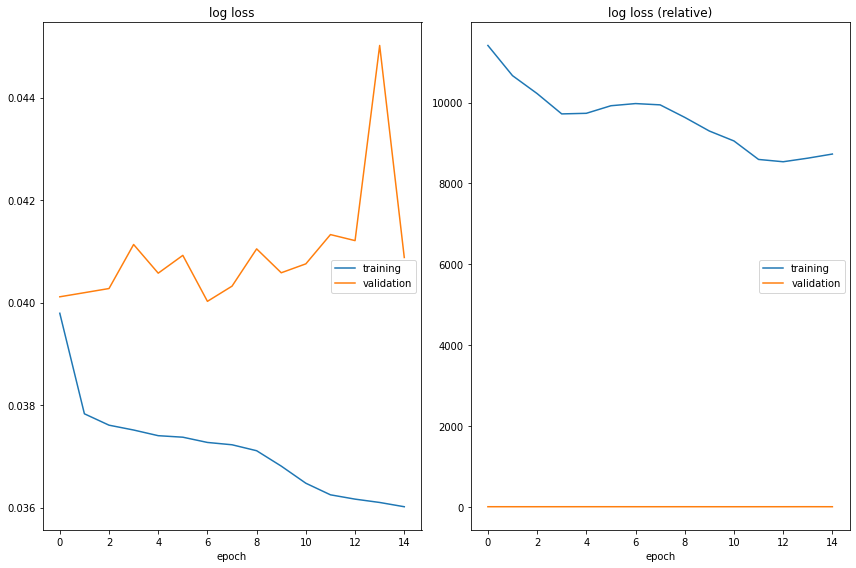

log loss
	training         	 (min:    0.036, max:    0.040, cur:    0.036)
	validation       	 (min:    0.040, max:    0.045, cur:    0.041)
log loss (relative)
	training         	 (min: 8537.218, max: 11414.283, cur: 8727.823)
	validation       	 (min:    1.867, max:    2.666, cur:    2.073)
Epoch:  14 | train loss: 3.601637e-02 | valid loss: 4.087944e-02 
      	| train loss (relative): 8.727823e+03 | valid loss (relative): 2.072534e+00 
Epoch 14 use: 32.53 second.

epoch 15 starting......


In [ ]:
autoencoder = train_model(autoencoder, 
                          train_loader = train_loader,
                          valid_loader = valid_loader,
                          test_loader = test_loader,
                          state_load = None,
                          n_epochs = 4000, 
                          lr = 1e-4,
                          shuffle = False,
                          weight_decay = weight_decay,
                          criterion_type = criterion_type,
                          seed = seed,
                          checksfcs = True,
                          optimizer = 'Adam',
                          adaptive = True,
                          adaptivepadded = True)

In [ ]:
autoencoder.encoder.orderings[0][autoencoder.decoder.orderings[0]]

In [ ]:
torch.save(autoencoder.state_dict, "0.025number2.pth")

### Other functions need to be add, like convert the result back to `csv`/`vtu` files.....

In [ ]:
# added functions to output vtu files from reconstruct
model_device = torch.device('cuda')
autoencoder = autoencoder.to(model_device)
save_path = 'reconstructed_FPC_CG'
import os
os.system(F'mkdir -p {save_path}')

In [ ]:
data_path = 'FPC_Re3900_CG_new/'
vtu_fields = ['Velocity']

In [ ]:
b

In [ ]:
result_vtu_to_vtu(data_path, save_path, vtu_fields, autoencoder, k.detach().numpy(), b.detach().numpy(), model_device = model_device)

Please find the reconstructed files in `reconstructed` folder